In [1]:
import warnings

import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display
from pylab import rcParams
from datetime import  datetime, timedelta
from pandas.tseries.offsets import BDay
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from   statsmodels.tsa.api import ExponentialSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings('ignore')

In [2]:
retail_data = pd.read_csv('../b. Datasets/Retail Sales/Retail Sales.csv')

In [3]:
retail_data.shape

(293, 2)

In [4]:
display(retail_data.head(2))
display(retail_data.head(2))

,ds,y
0,1992-01-01,146376
1,1992-02-01,147079


,ds,y
0,1992-01-01,146376
1,1992-02-01,147079


In [5]:
retail_data.describe().T

,count,mean,std,min,25%,50%,75%,max
y,293.0,308971.31058,86084.323897,146376.0,234503.0,314051.0,375795.0,518253.0


In [6]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      293 non-null    object
 1   y       293 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.7+ KB


In [7]:
retail_data.isna().sum()

ds    0
y     0
dtype: int64

In [8]:
retail_data['ds'] = pd.to_datetime(retail_data['ds'], 
                                   errors='coerce')

In [9]:
retail_data.isna().sum()

ds    0
y     0
dtype: int64

In [10]:
retail_data.set_index('ds', inplace=True)

In [11]:
retail_data.head(5)

,y
ds,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


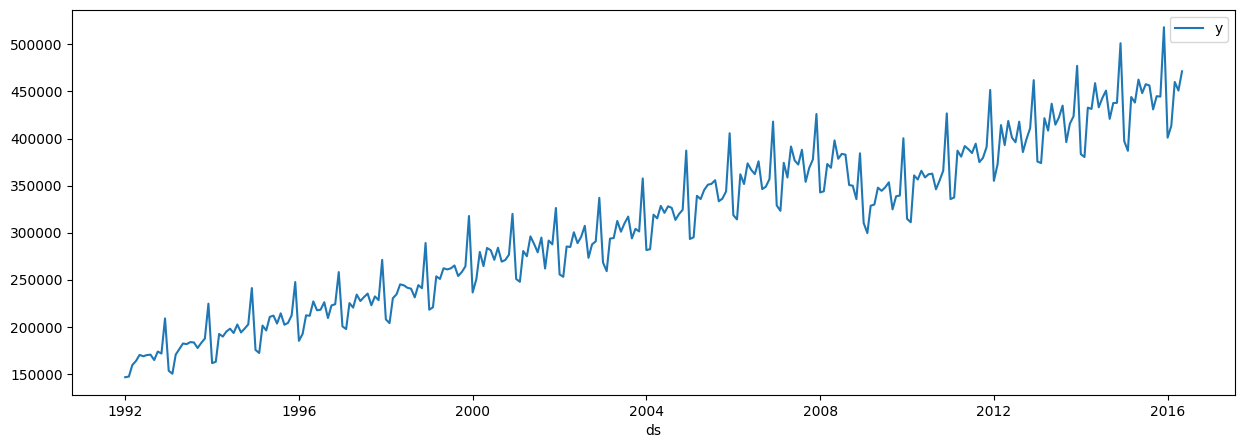

In [12]:
plt.figure(figsize=(15, 5))
sns.lineplot(retail_data)
plt.show()

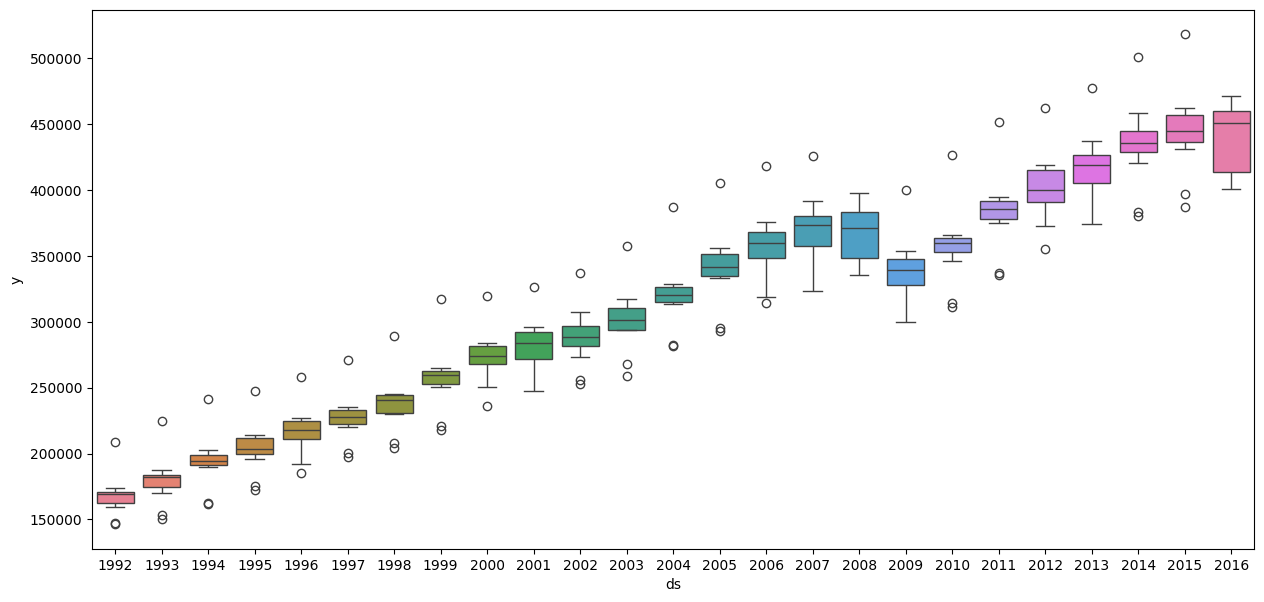

In [13]:
plt.figure(figsize=(15, 7))
sns.boxplot(x=retail_data.index.year, y=retail_data.y, palette='husl')
plt.show()

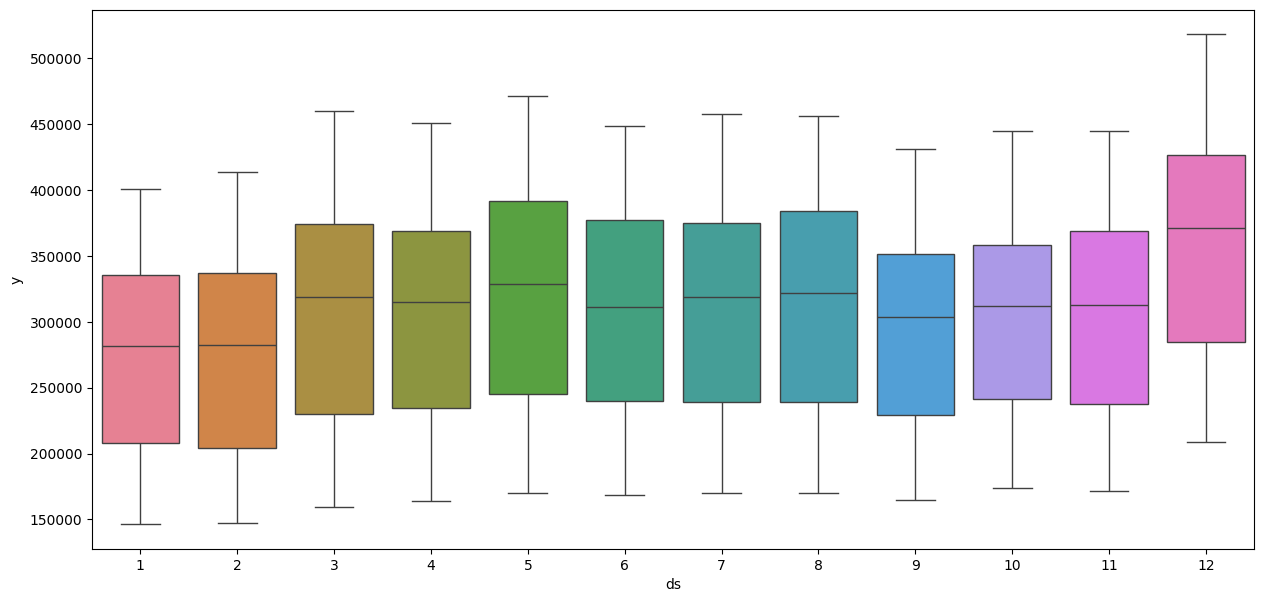

In [14]:
plt.figure(figsize=(15, 7))
sns.boxplot(x=retail_data.index.month, y=retail_data.y, palette='husl')
plt.show()

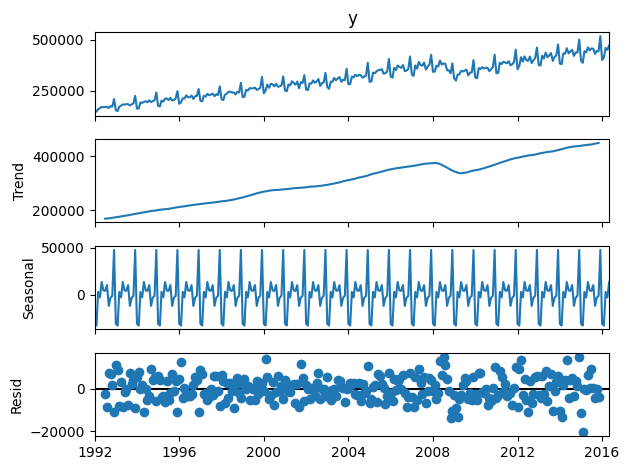

In [15]:
decom1 = seasonal_decompose(retail_data.y, 
                            model='additive')
decom1.plot();

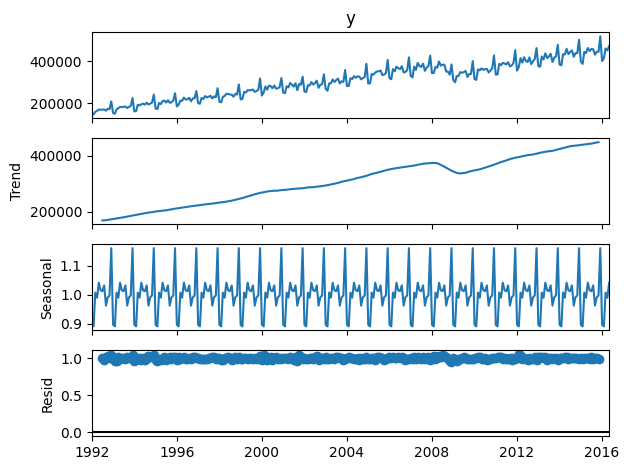

In [16]:
decom2 = seasonal_decompose(retail_data.y, 
                            model='multiplicative')
decom2.plot();

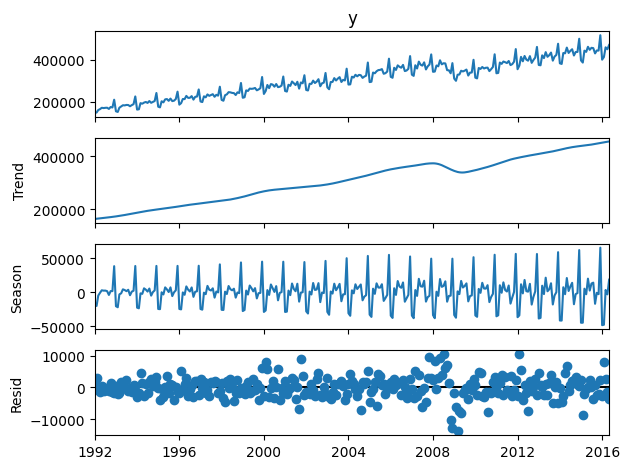

In [17]:
decompose = STL(retail_data.y).fit()
decompose.plot();

In [18]:
adf_stat = adfuller(retail_data)
p_val = adf_stat[1]
significance_level = 0.05

if p_val < significance_level:
    print("Null hypothesis can be rejected. The data is stationary at 95% confidence.")
else:
    print("Null hypothesis cannot be rejected. The data is not stationary at 95% confidence interval.")

Null hypothesis cannot be rejected. The data is not stationary at 95% confidence interval.


In [19]:
retail_data_1diff = retail_data.diff().dropna()

In [20]:
adf_stat = adfuller(retail_data_1diff)
p_val = adf_stat[1]
if p_val < significance_level:
    print("Null hypothesis can be rejected. The data is stationary at 95% confidence level")
else:
    print("Null hypothesis cannot be rejected. The data is not stationary at 95% confidence.")

Null hypothesis can be rejected. The data is stationary at 95% confidence level


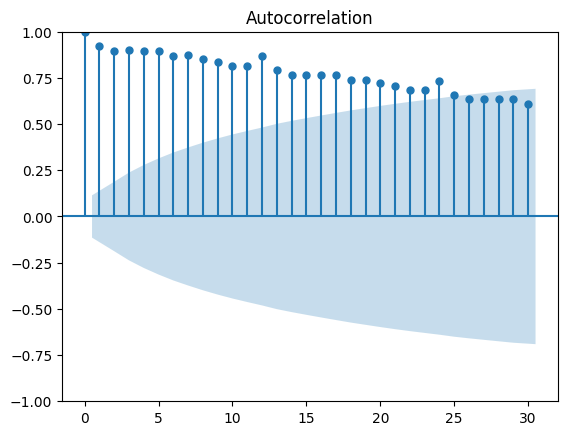

In [21]:
plot_acf(retail_data, lags=30);

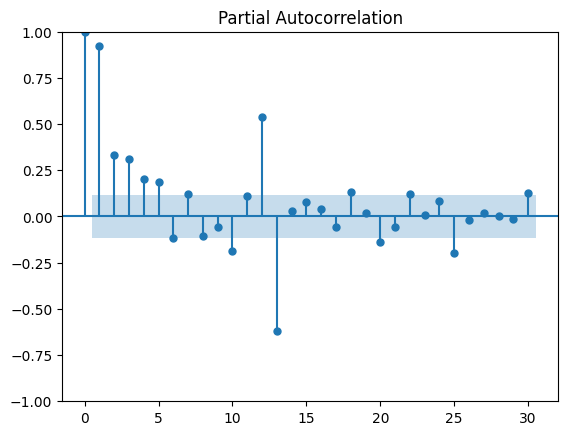

In [22]:
plot_pacf(retail_data, lags=30);

- ACF Plot: The gradual decay in the ACF suggests an autoregressive (AR) process rather than a moving average (MA) process. In an MA(q) process, we would expect a sharp cutoff after q lags.
- PACF Plot: The PACF cuts off sharply after lag 1, which indicates an AR(1) process.

Conclusion:
The data follows an AR(1) process because:

- The ACF gradually decays, ruling out a pure MA process.
- The PACF cuts off sharply after lag 1, indicating an AR(1) model.
- So, an AR(1) model is a good choice.

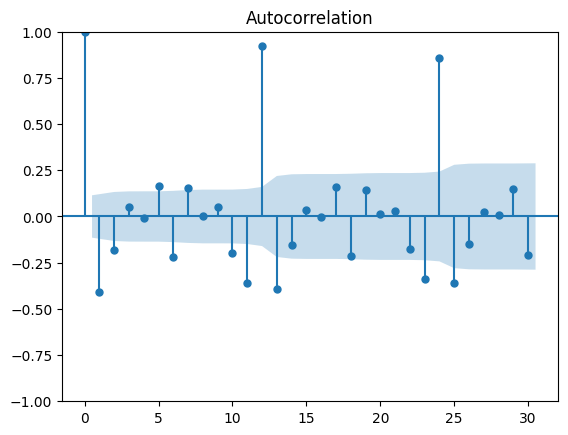

In [23]:
plot_acf(retail_data_1diff, lags=30);

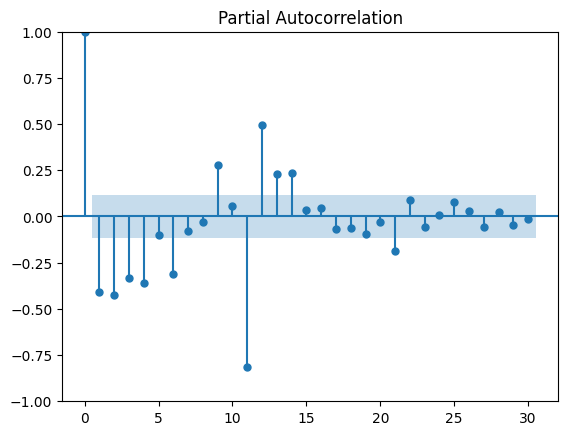

In [24]:
plot_pacf(retail_data_1diff, lags=30);

In [25]:
test_start = int(np.floor(len(retail_data) * 0.8) + 1)
train_data = retail_data[:test_start]
test_data = retail_data[test_start: ]

In [26]:
train_data.shape, test_data.shape

((235, 1), (58, 1))

In [27]:
display(train_data.head(2))
display(test_data.head(2))

,y
ds,
1992-01-01,146376
1992-02-01,147079


,y
ds,
2011-08-01,394548
2011-09-01,374895


In [28]:
p = q = range(0, 4)
d = range(1, 2)

pdq = list(itertools.product(p, d, q))
pdq

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3)]

In [29]:
aic_df = []
for order in pdq:
    arima_model = ARIMA(train_data, 
                        order=order, 
                        enforce_invertibility=False, 
                        enforce_stationarity=False)
    result_arima = arima_model.fit()
    aic_val = result_arima.aic
    aic_df.append((order, aic_val))
    print(f"Calc complete for {order}. AIC {aic_val}")

aic_df = pd.DataFrame(data=aic_df, columns=['Order', 'AIC'])

Calc complete for (0, 1, 0). AIC 5455.291835847448
Calc complete for (0, 1, 1). AIC 5316.8203009936415
Calc complete for (0, 1, 2). AIC 5295.08456078762
Calc complete for (0, 1, 3). AIC 5253.801984131038
Calc complete for (1, 1, 0). AIC 5415.687714147645
Calc complete for (1, 1, 1). AIC 5318.181445903257
Calc complete for (1, 1, 2). AIC 5298.264773662599
Calc complete for (1, 1, 3). AIC 5251.7332453934705
Calc complete for (2, 1, 0). AIC 5351.559440371075
Calc complete for (2, 1, 1). AIC 5311.15041187136
Calc complete for (2, 1, 2). AIC 5276.790487276103
Calc complete for (2, 1, 3). AIC 5251.379918763614
Calc complete for (3, 1, 0). AIC 5306.933009142781
Calc complete for (3, 1, 1). AIC 5287.639863175211
Calc complete for (3, 1, 2). AIC 5292.890131064532
Calc complete for (3, 1, 3). AIC 5252.792518376932


In [30]:
aic_df

,Order,AIC
0,"(0, 1, 0)",5455.291836
1,"(0, 1, 1)",5316.820301
2,"(0, 1, 2)",5295.084561
3,"(0, 1, 3)",5253.801984
4,"(1, 1, 0)",5415.687714
5,"(1, 1, 1)",5318.181446
6,"(1, 1, 2)",5298.264774
7,"(1, 1, 3)",5251.733245
8,"(2, 1, 0)",5351.559440
9,"(2, 1, 1)",5311.150412


In [31]:
aic_df.sort_values(by="AIC", ascending=True, inplace=True)
aic_df

,Order,AIC
11,"(2, 1, 3)",5251.379919
7,"(1, 1, 3)",5251.733245
15,"(3, 1, 3)",5252.792518
3,"(0, 1, 3)",5253.801984
10,"(2, 1, 2)",5276.790487
13,"(3, 1, 1)",5287.639863
14,"(3, 1, 2)",5292.890131
2,"(0, 1, 2)",5295.084561
6,"(1, 1, 2)",5298.264774
12,"(3, 1, 0)",5306.933009


In [32]:
arima_model = ARIMA(train_data, 
                    order=(2, 1, 3), 
                    enforce_invertibility=False, 
                    enforce_stationarity=False)
result_arima = arima_model.fit()

In [33]:
arima_forecast = result_arima.forecast(len(test_data))
mean_squared_error(test_data, arima_forecast, squared=False)

49177.95472050193

In [34]:
mean_absolute_percentage_error(test_data, arima_forecast)

0.08978673755135282

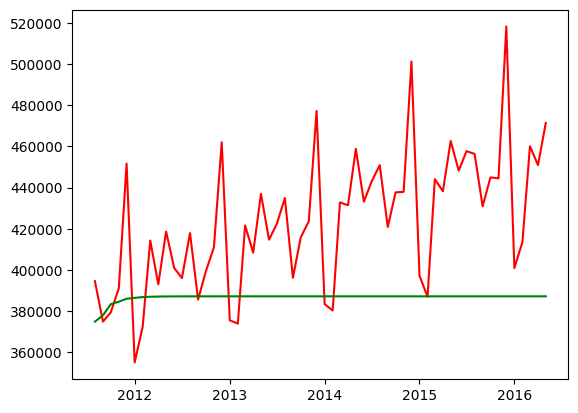

In [35]:
plt.plot(test_data.index, test_data, color='red')
plt.plot(test_data.index, arima_forecast, color='green')

## Exponential Smothing

In [36]:
es_model = ExponentialSmoothing(train_data, 
                                trend=None, 
                                seasonal=None, 
                                initialization_method='estimated')
result_es = es_model.fit(optimized=True)

In [37]:
forecast_es = result_es.forecast(len(test_data))

In [38]:
mean_squared_error(test_data, forecast_es, squared=False)

56750.649030830566

In [39]:
mean_absolute_percentage_error(test_data, forecast_es)

0.10662793399348135

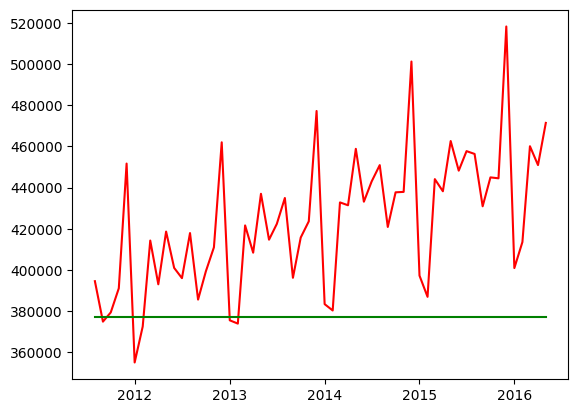

In [40]:
plt.plot(test_data.index, test_data, color='red')
plt.plot(test_data.index, forecast_es, color='green')

In [41]:
residuals = test_data['y'] - forecast_es

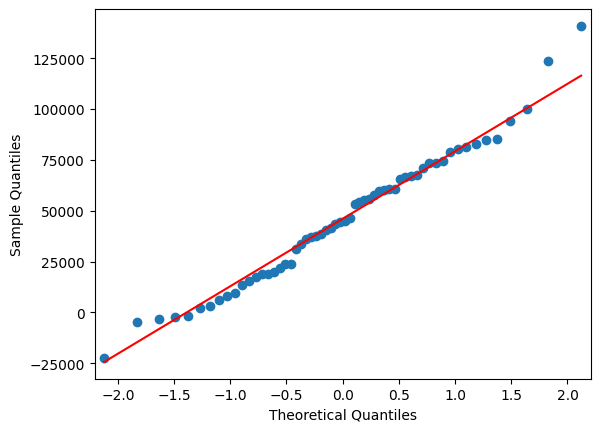

In [42]:
qqplot(residuals, line='s');

## Model Tuning

In [43]:
alphas = betas = gammas = np.linspace(0.01, 0.99, 10)

best_mape_score, best_params = float("inf"), None
count = 0
for α in alphas:
    for β in betas:
        for γ in gammas:
            count += 1
            try:
                model = ExponentialSmoothing(train_data["y"], trend="mul", seasonal="mul", seasonal_periods=12)
                fitted_model = model.fit(smoothing_level=α, smoothing_trend=β, smoothing_seasonal=γ)
                forecast_for_trial = fitted_model.forecast(len(test_data))
                mape_val = mean_absolute_percentage_error(test_data, forecast_for_trial)
                
                if mape_val < best_mape_score:
                    best_mape_score = mape_val
                    best_params = (α, β, γ)
            except Exception as e:
                continue

print("Best Parameters:", best_params)

Best Parameters: (0.22777777777777777, 0.01, 0.44555555555555554)


In [44]:
tes_model = ExponentialSmoothing(train_data,
                                 trend='mul', 
                                 seasonal='mul', 
                                 initialization_method='estimated')
result_tes = tes_model.fit(smoothing_level=best_params[0], 
                           smoothing_trend=best_params[1],
                           smoothing_seasonal=best_params[2],
                           optimized=False)

In [45]:
result_tes.summary()

Dep. Variable:,y,No. Observations:,235
Model:,ExponentialSmoothing,SSE,12368152606.793
Optimized:,False,AIC,4210.019
Trend:,Multiplicative,BIC,4265.373
Seasonal:,Multiplicative,AICC,4213.186
Seasonal Periods:,12,Date:,"Thu, 13 Mar 2025"
Box-Cox:,False,Time:,19:55:36
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2277778,alpha,False
smoothing_trend,0.0100000,beta,False


In [46]:
forecast_tes = result_tes.forecast(len(test_data))

In [47]:
mean_squared_error(test_data, forecast_tes, squared=False)

7173.295870628179

In [48]:
mean_absolute_percentage_error(test_data, forecast_tes)

0.01327314510764651

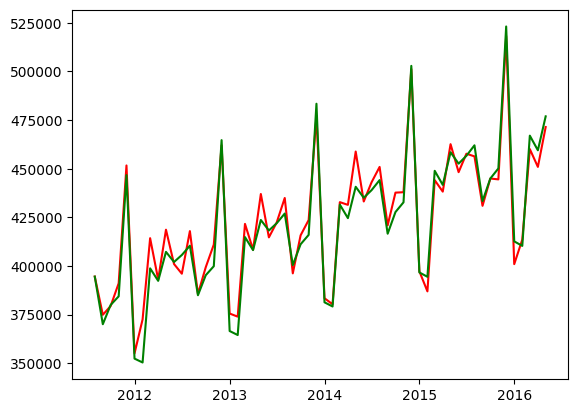

In [49]:
plt.plot(test_data.index, test_data, color='red')
plt.plot(test_data.index, forecast_tes, color='green')

## Final model and prediction

In [50]:
tes_final = ExponentialSmoothing(retail_data, 
                                 trend='mul', 
                                 seasonal='mul', 
                                 initialization_method='estimated')
final_tes = tes_final.fit(smoothing_level=best_params[0], 
                           smoothing_trend=best_params[1],
                           smoothing_seasonal=best_params[2],
                           optimized=False)

In [51]:
final_tes.summary()

Dep. Variable:,y,No. Observations:,293
Model:,ExponentialSmoothing,SSE,15073598451.618
Optimized:,False,AIC,5234.519
Trend:,Multiplicative,BIC,5293.402
Seasonal:,Multiplicative,AICC,5237.015
Seasonal Periods:,12,Date:,"Thu, 13 Mar 2025"
Box-Cox:,False,Time:,19:55:36
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2277778,alpha,False
smoothing_trend,0.0100000,beta,False


In [52]:
forecast_final = final_tes.forecast(30)

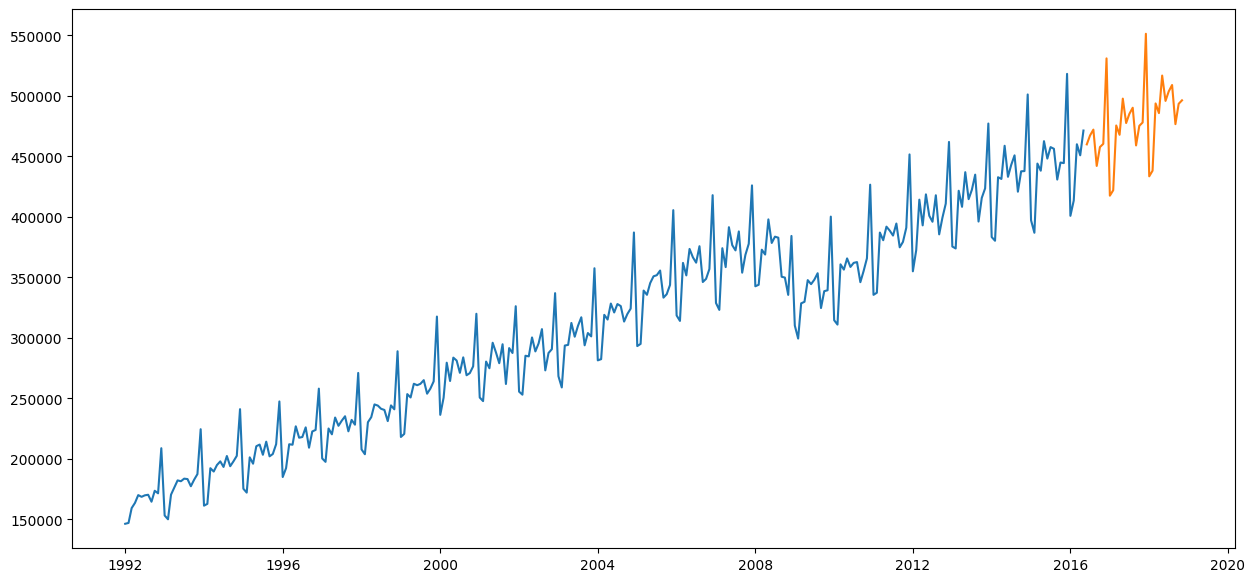

In [53]:
plt.figure(figsize=(15, 7))
plt.plot(retail_data.index, retail_data.y)
plt.plot(forecast_final)
plt.show()

In [54]:
submission_df = pd.DataFrame(forecast_final, columns=['Sales'])

In [55]:
display(submission_df.head(2))
display(submission_df.tail(2))

,Sales
2016-06-01,459983.459794
2016-07-01,467311.438378


,Sales
2018-10-01,493510.601116
2018-11-01,496387.093297


In [56]:
submission_df.to_csv('../d. Output Files/Retail Sales/Retail Sales Forecast.csv', index=True)